In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
from mlagents_envs.environment import UnityEnvironment
from gym_unity.envs import UnityToGymWrapper

from ddpg_agent import Agent

%matplotlib inline

In [2]:
unity_env = UnityEnvironment(file_name='C:/Users/zizhong/Documents/A1/case/Unity/Unity_Rocket/My project.exe')
env = UnityToGymWrapper(unity_env, allow_multiple_obs=True) #uint8_visual=True

[INFO] Connected to Unity environment with package version 2.2.1-exp.1 and communication version 1.5.0
[INFO] Connected new brain: My Behavior?team=0


C:\Users\zizhong\.conda\envs\rl\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
env.reset()

[array([-2.2467074 , 10.920708  , -2.0366035 ,  0.01516462, -0.19266401,
         0.01776515], dtype=float32)]

In [4]:
for episode in range(10):
    intial__obseration = env.reset()
    done = False
    episode_rewards = 0
    while not done:
        observation, reward, done, info = env.step(env.action_space.sample())
        episode_rewards += reward
    print("Total reward this episode:{}".format(episode_rewards))

Total reward this episode:-762.0392570495605
Total reward this episode:-300.576051235199
Total reward this episode:-363.0093240737915
Total reward this episode:-81.35209536552429
Total reward this episode:-308.5232102870941
Total reward this episode:-265.46425771713257
Total reward this episode:-946.7698769569397
Total reward this episode:-715.2638268470764
Total reward this episode:-315.20570158958435
Total reward this episode:-345.3943157196045


In [5]:
print(env.action_space.sample())

[-0.89802927  0.32571438  0.9188607 ]


In [6]:
agent = Agent(state_size=6,
             action_size=3,
             random_seed=2)

In [7]:
%%time
n_episodes = 1000
agent.noise.sigma = 2
scores = []
success = []
for i_episode in  range(1, n_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            success += [reward>0]
            break
    scores += [score]
    print('\rEpisode', i_episode, 'Average Score: %.2f'%np.mean(scores[-20:]),
         'Success rate %.2f'%np.mean(success[-20:]), 'Noise std: %.3f'%agent.noise.sigma,end="")
    agent.noise.sigma *= 0.9 #0.995
    torch.save(agent.actor_local.state_dict(), 'v1_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'v1_critic.pth')

C:\Users\zizhong\.conda\envs\rl\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1000 Average Score: -107.84 Success rate 0.00 Noise std: 0.000Wall time: 18min 6s


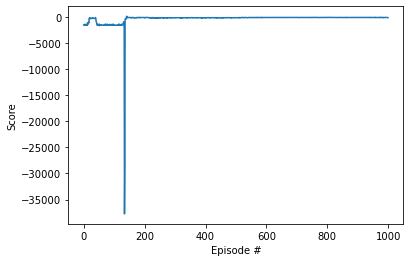

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(scores[-1000:])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

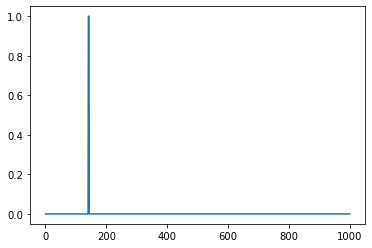

In [9]:
plt.plot(success[-1000:])

In [10]:
agent.actor_local.load_state_dict(torch.load('v1_actor.pth'))
agent.critic_local.load_state_dict(torch.load('v1_critic.pth'))

<All keys matched successfully>

In [11]:
for _ in range(5):
    state = env.reset()
    total_reward = 0
    while True:
        action = agent.act(state, add_noise=False)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            text = 'Success' if reward>0 else 'Failed'
            print(text, total_reward)
            break

Failed -127.65067768096924
Failed -116.53140640258789
Failed -129.84750652313232
Failed -148.56852054595947
Failed -94.50333881378174


In [12]:
env.close()